In [1]:
%matplotlib inline

In [436]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dask.dataframe as dd

from sklearn.linear_model import LogisticRegression
from scipy.signal import find_peaks, peak_widths

import plotly.express as px
import plotly.graph_objects as go

# Metro in Porto, Portugal

References:
- [data](https://zenodo.org/record/6854240#.YvuPmHZBzBV)
- [paper](https://arxiv.org/pdf/2207.05466.pdf#view=fitH&toolbar=1)

Columns:

ANALOGUE SIGNALS
 - `TP2` - compressor pressure
 - `TP3` - pneumatic panel pressure
 - `H1` - valve?
 - `DV_pressure` - pressure drop?
 - `Reservoirs` - ?
 - `Oil_temperature` -  temperature of the oil present on the compressor
 - `Flowmeter` - ?
 - `Motor_current` - motor current; 0 A when compressor is off, 4A when compressor is working offloaded, 7A when compressor is under load
 
DIGITAL SIGNALS

(only assume two values: zero when inactive or one when activated)
 - `COMP` -  air intake valve on the compressor; 1 = no admission of air on the compressor
 - `DV_eletric` - compressor outlet valve; 1 = compressor is under load
 - `Towers` - defines which tower is working; 0 = tower 1 is working
 - `MPG` -  intake valve to start the compressor under load
 - `LPS` - 1 = pressure < 7 bars
 - `Pressure_switch` - ?
 - `Oil_level` - 1 = oil is below expected level
 - `Caudal_impulses` - ?
 
 GPS DATA
 - `gpsLong` - longitude
 - `gpsLat` - latitude
 - `gpsSpeed` - speed of the train
 - `gpsQuality` - 1 = (guess) missing

Failures:

| No   |   Type      | Component   |     Start      |      End       |
|------|-------------|-------------|----------------|----------------|
|    1 | Air  Leak   | Air Dryer   | 28-2-22 21:53  | 1-03-22 02:00  |
|    2 | Air  Leak   | Clients     | 23-3-22 14:54  | 23-03-22 15:24 |
|    3 | Oil  Leak   | Compressor  | 30-5-22 12:00  | 02-06-22 06:18 |

Data collected from January to June 2022.

Data points in total: 10979547.

### Estimate the line number for each of the failures

In [133]:
failure_dates = pd.to_datetime([
    "28-2-22 21:53",
    "23-3-22 14:54",
    "30-5-22 12:00",
])

data_collection_start = pd.to_datetime("1-1-22 00:00")
data_collection_end = pd.to_datetime("30-6-22 23:59")

In [134]:
dates = pd.Series([
    data_collection_start,
    *failure_dates,
    data_collection_end,
])

records = pd.DataFrame({
    "date": dates,
    "line_num": [0, np.NaN, np.NaN, np.NaN, 10979547]
})

In [135]:
time_differences = records.date - records.date[0]
elapsed_seconds = time_differences.apply(lambda x: x.total_seconds())
records["normalized_time"] = elapsed_seconds / elapsed_seconds[4]
records

date    line_num  normalized_time
0 2022-01-01 00:00:00         0.0         0.000000
1 2022-02-28 21:53:00         NaN         0.325481
2 2022-03-23 14:54:00         NaN         0.450946
3 2022-05-30 12:00:00         NaN         0.825970
4 2022-06-30 23:59:00  10979547.0         1.000000

In [142]:
def lerp(a, b, t):
    """Linear interpolation between `a` and `b`. `t` is between [0, 1]."""
    return a + (b - a) * t

a, b = records.line_num[0], records.line_num[4]

records.line_num = [np.int32(lerp(a, b, t)) for t in records.normalized_time]

In [143]:
records

date  line_num  normalized_time
0 2022-01-01 00:00:00         0         0.000000
1 2022-02-28 21:53:00   3573632         0.325481
2 2022-03-23 14:54:00   4951177         0.450946
3 2022-05-30 12:00:00   9068776         0.825970
4 2022-06-30 23:59:00  10979547         1.000000

## Dask

In [3]:
# # Split the raw data to 10 parts

# df = dd.read_csv("../../dataset_train.csv")
# df = df.repartition(npartitions=10)
# df.to_csv("file_*.csv")

# reader = pd.read_csv("../../file_0.csv", chunksize=10_000)

In [7]:
%timeit dd.read_csv("../../data/dataset_train.csv")

11.4 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
metro = dd.read_csv("../../data/dataset_train.csv")

In [33]:
metro.columns

Index(['timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Flowmeter', 'Motor_current', 'COMP', 'DV_eletric',
       'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level',
       'Caudal_impulses', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'],
      dtype='object')

In [39]:
%timeit pd.to_datetime(metro.timestamp, infer_datetime_format=True)

1min 2s ± 8.38 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
metro.divisions

(None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None)

In [18]:
metro.partitions[1]

Dask DataFrame Structure:
              timestamp      TP2      TP3       H1 DV_pressure Reservoirs Oil_temperature Flowmeter Motor_current   COMP DV_eletric Towers    MPG    LPS Pressure_switch Oil_level Caudal_impulses  gpsLong   gpsLat gpsSpeed gpsQuality
npartitions=1                                                                                                                                                                                                                           
                 object  float64  float64  float64     float64    float64         float64   float64       float64  int64      int64  int64  int64  int64           int64     int64           int64  float64  float64    int64      int64
                    ...      ...      ...      ...         ...        ...             ...       ...           ...    ...        ...    ...    ...    ...             ...       ...             ...      ...      ...      ...        ...
Dask Name: blocks, 27 tasks

## Pandas

### Read the data and get basic info.

In [245]:
column_names = pd.read_csv("../../data/dataset_train.csv", nrows=0).columns

metro = pd.read_csv("../../data/dataset_train.csv", skiprows = 500_000, nrows = 200_000, header=None)

metro.columns = column_names

In [246]:
metro.shape

(200000, 21)

In [247]:
metro.head()

timestamp    TP2    TP3     H1  DV_pressure  Reservoirs  \
0  2022-01-08 00:53:13 -0.006  8.766  8.772       -0.028       1.652   
1  2022-01-08 00:53:14 -0.006  8.764  8.772       -0.026       1.652   
2  2022-01-08 00:53:15 -0.006  8.764  8.770       -0.026       1.650   
3  2022-01-08 00:53:16 -0.006  8.762  8.770       -0.028       1.650   
4  2022-01-08 00:53:17 -0.006  8.764  8.770       -0.028       1.652   

   Oil_temperature  Flowmeter  Motor_current  COMP  ...  Towers  MPG  LPS  \
0           66.400  19.012250         0.0025     1  ...       1    1    0   
1           66.325  19.012250         0.0000     1  ...       1    1    0   
2           66.375  19.002906         0.0025     1  ...       1    1    0   
3           66.350  19.002906         0.0025     1  ...       1    1    0   
4           66.375  19.002906         0.0000     1  ...       1    1    0   

   Pressure_switch  Oil_level  Caudal_impulses  gpsLong  gpsLat  gpsSpeed  \
0                0          0                0 -8.61664  41.157         0   
1                0          0                0 -8.61664  41.157         0   
2                0          0                0 -8.61664  41.157         0   
3                0          0                0 -8.61664  41.157         0   
4                0          0                0 -8.61664  41.157         0   

   gpsQuality  
0           1  
1           1  
2           1  
3           1  
4           1  

[5 rows x 21 columns]

In [248]:
metro.dtypes

timestamp           object
TP2                float64
TP3                float64
H1                 float64
DV_pressure        float64
Reservoirs         float64
Oil_temperature    float64
Flowmeter          float64
Motor_current      float64
COMP                 int64
DV_eletric           int64
Towers               int64
MPG                  int64
LPS                  int64
Pressure_switch      int64
Oil_level            int64
Caudal_impulses      int64
gpsLong            float64
gpsLat             float64
gpsSpeed             int64
gpsQuality           int64
dtype: object

### Check for missing values.
Conclusion: none are missing.

In [249]:
metro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   timestamp        200000 non-null  object 
 1   TP2              200000 non-null  float64
 2   TP3              200000 non-null  float64
 3   H1               200000 non-null  float64
 4   DV_pressure      200000 non-null  float64
 5   Reservoirs       200000 non-null  float64
 6   Oil_temperature  200000 non-null  float64
 7   Flowmeter        200000 non-null  float64
 8   Motor_current    200000 non-null  float64
 9   COMP             200000 non-null  int64  
 10  DV_eletric       200000 non-null  int64  
 11  Towers           200000 non-null  int64  
 12  MPG              200000 non-null  int64  
 13  LPS              200000 non-null  int64  
 14  Pressure_switch  200000 non-null  int64  
 15  Oil_level        200000 non-null  int64  
 16  Caudal_impulses  200000 non-null  int6

### Convert `timestamp` to `datatime`, reset index.

In [250]:
metro.index = pd.to_datetime(metro.timestamp)
metro = metro.drop(columns = 'timestamp')
metro.index.dtype

dtype('<M8[ns]')

In [251]:
metro.index[0], metro.index[-1]

(Timestamp('2022-01-08 00:53:13'), Timestamp('2022-01-10 20:26:29'))

### Examine cyclic variables

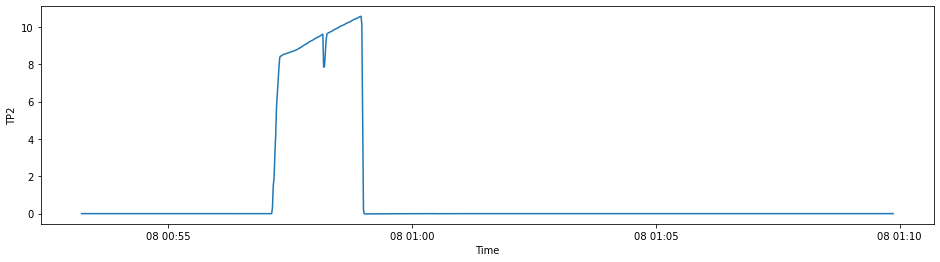

In [253]:
plt.figure(figsize = (16, 4))
plt.plot(metro[:1000].TP2)
plt.xlabel("Time")
plt.ylabel("TP2")
plt.show()

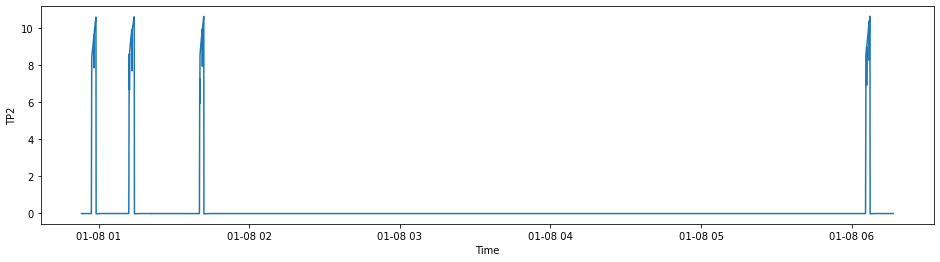

In [254]:
plt.figure(figsize = (16, 4))
plt.plot(metro[:5000].TP2)
plt.xlabel("Time")
plt.ylabel("TP2")
plt.show()

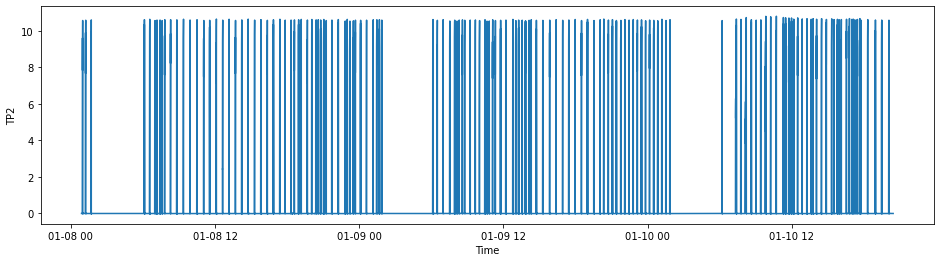

In [255]:
plt.figure(figsize = (16, 4))
plt.plot(metro.TP2)
plt.xlabel("Time")
plt.ylabel("TP2")
plt.show()

### Examine single day

In [216]:
data_from_single_day = metro[metro.index.day == 2]

In [218]:
data_from_single_day

TP2    TP3     H1  DV_pressure  Reservoirs  \
timestamp                                                           
2022-01-02 00:00:00 -0.012  8.654  8.654       -0.028       1.596   
2022-01-02 00:00:01 -0.014  8.650  8.654       -0.030       1.592   
2022-01-02 00:00:02 -0.012  8.652  8.654       -0.030       1.596   
2022-01-02 00:00:03 -0.012  8.652  8.652       -0.028       1.592   
2022-01-02 00:00:04 -0.010  8.652  8.652       -0.030       1.594   
...                    ...    ...    ...          ...         ...   
2022-01-02 23:59:55 -0.008  8.962  8.962       -0.028       1.610   
2022-01-02 23:59:56 -0.010  8.958  8.962       -0.028       1.608   
2022-01-02 23:59:57 -0.010  8.958  8.960       -0.028       1.610   
2022-01-02 23:59:58 -0.008  8.956  8.956       -0.028       1.610   
2022-01-02 23:59:59 -0.008  8.954  8.954       -0.028       1.610   

                     Oil_temperature  Flowmeter  Motor_current  COMP  \
timestamp                                                              
2022-01-02 00:00:00           52.100   18.86275         0.0075     1   
2022-01-02 00:00:01           52.300   18.86275         0.0075     1   
2022-01-02 00:00:02           52.200   18.86275         0.0075     1   
2022-01-02 00:00:03           52.250   18.86275         0.0075     1   
2022-01-02 00:00:04           52.225   18.86275         0.0075     1   
...                              ...        ...            ...   ...   
2022-01-02 23:59:55           63.050   19.01225         0.0050     1   
2022-01-02 23:59:56           63.050   19.01225         0.0050     1   
2022-01-02 23:59:57           63.025   19.01225         0.0050     1   
2022-01-02 23:59:58           63.075   19.01225         0.0050     1   
2022-01-02 23:59:59           63.025   19.01225         0.0050     1   

                     DV_eletric  Towers  MPG  LPS  Pressure_switch  Oil_level  \
timestamp                                                                       
2022-01-02 00:00:00           0       1    1    0                0          0   
2022-01-02 00:00:01           0       1    1    0                0          0   
2022-01-02 00:00:02           0       1    1    0                0          0   
2022-01-02 00:00:03           0       1    1    0                0          0   
2022-01-02 00:00:04           0       1    1    0                0          0   
...                         ...     ...  ...  ...              ...        ...   
2022-01-02 23:59:55           0       1    1    0                0          0   
2022-01-02 23:59:56           0       1    1    0                0          0   
2022-01-02 23:59:57           0       1    1    0                0          0   
2022-01-02 23:59:58           0       1    1    0                0          0   
2022-01-02 23:59:59           0       1    1    0                0          0   

                     Caudal_impulses  gpsLong   gpsLat  gpsSpeed  gpsQuality  
timestamp                                                                     
2022-01-02 00:00:00                0 -8.54318  41.1836        38           1  
2022-01-02 00:00:01                0 -8.54322  41.1837        39           1  
2022-01-02 00:00:02                0 -8.54326  41.1838        40           1  
2022-01-02 00:00:03                0 -8.54331  41.1839        39           1  
2022-01-02 00:00:04                0 -8.54335  41.1840        39           1  
...                              ...      ...      ...       ...         ...  
2022-01-02 23:59:55                0 -8.65856  41.2118         0           1  
2022-01-02 23:59:56                0 -8.65856  41.2118         0           1  
2022-01-02 23:59:57                0 -8.65856  41.2118         0           1  
2022-01-02 23:59:58                0 -8.65856  41.2118         0           1  
2022-01-02 23:59:59                0 -8.65856  41.2118         0           1  

[72001 rows x 20 columns]

### Inspect the third failure

In [174]:
third_failure = pd.read_csv("../../data/dataset_train.csv", skiprows = 10_700_000, nrows = 200_000)

In [175]:
third_failure.columns = ['timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Flowmeter', 'Motor_current', 'COMP', 'DV_eletric',
       'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level',
       'Caudal_impulses', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']

In [176]:
third_failure.shape

(200000, 21)

In [177]:
third_failure.index = pd.to_datetime(third_failure.timestamp)
third_failure = third_failure.drop(columns = 'timestamp')
third_failure.index.dtype

dtype('<M8[ns]')

The last and the first date in the interval. Third failure occurred on `2022-05-30 12:00:00`.

In [178]:
third_failure.index[0], third_failure.index[-1]

(Timestamp('2022-05-29 18:10:52'), Timestamp('2022-06-01 13:44:08'))

In [180]:
day_of_failure = third_failure[third_failure.index.day == 30]

In [182]:
day_of_failure.head(2)

TP2    TP3     H1  DV_pressure  Reservoirs  \
timestamp                                                           
2022-05-30 00:00:00 -0.014  9.818  9.290       -0.032       1.464   
2022-05-30 00:00:01 -0.012  9.816  9.288       -0.032       1.464   

                     Oil_temperature  Flowmeter  Motor_current  COMP  \
timestamp                                                              
2022-05-30 00:00:00           68.625  19.367313         3.8225     1   
2022-05-30 00:00:01           68.525  19.367313         3.7975     1   

                     DV_eletric  Towers  MPG  LPS  Pressure_switch  Oil_level  \
timestamp                                                                       
2022-05-30 00:00:00           0       1    1    0                0          0   
2022-05-30 00:00:01           0       1    1    0                0          0   

                     Caudal_impulses  gpsLong  gpsLat  gpsSpeed  gpsQuality  
timestamp                                                                    
2022-05-30 00:00:00                0      0.0     0.0         0           0  
2022-05-30 00:00:01                0      0.0     0.0         0           0

In [186]:
lunch_time = day_of_failure[(11 <= day_of_failure.index.hour) & (day_of_failure.index.hour <= 13)]

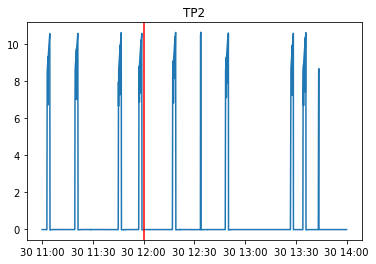

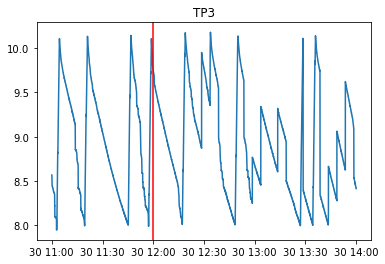

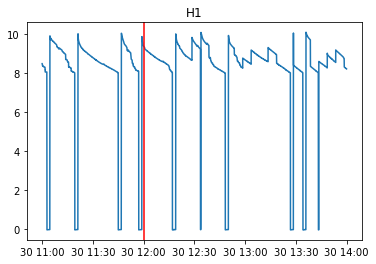

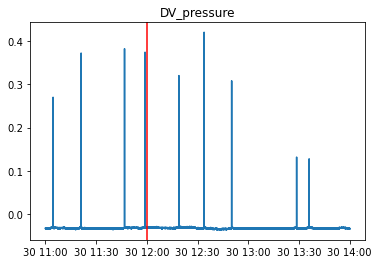

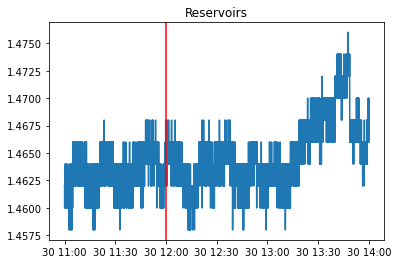

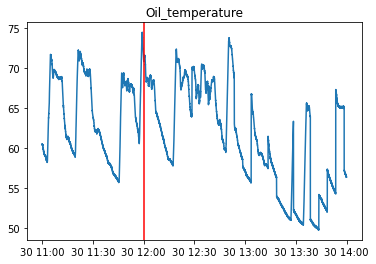

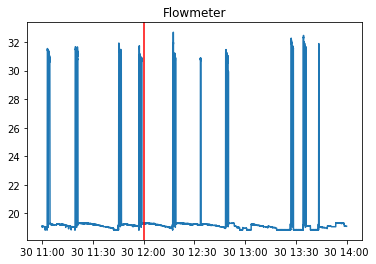

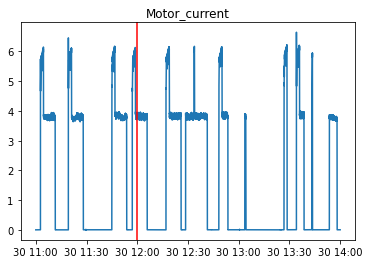

In [204]:
def plot_variable(df, var, vline):
    plt.plot(df[var])
    plt.title(var)
    plt.axvline(vline, c='red')
    plt.show()

columns_with_continous_variables = ['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature', 'Flowmeter', 'Motor_current',]

for c in columns_with_continous_variables:
    plot_variable(lunch_time, c, pd.to_datetime("2022-05-30 12:00:00"))

### Plot `speed` on the map

In [380]:
speed_to_plot = metro[["gpsLong", "gpsLat", "gpsSpeed", "gpsQuality"]]
speed_to_plot = speed_to_plot[speed_to_plot.index.hour.isin([10, 11])]
speed_to_plot = speed_to_plot[speed_to_plot.gpsQuality == 1]

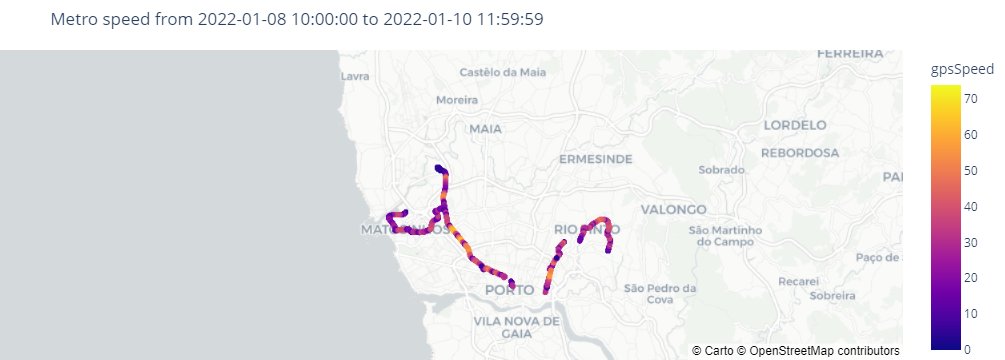

In [390]:
title = f"Metro speed from {speed_to_plot.index[0]} to {speed_to_plot.index[-1]}"

fig = px.scatter_mapbox(speed_to_plot, lat="gpsLat", lon="gpsLong", color = "gpsSpeed", zoom=10, title=title)

fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

In [382]:
speed_to_plot_2 = speed_to_plot[:]

In [383]:
speed_to_plot_2.gpsLong = speed_to_plot_2.gpsLong.round(3)
speed_to_plot_2.gpsLat = speed_to_plot_2.gpsLat.round(3)

In [384]:
mean_speed = pd.DataFrame(speed_to_plot_2.groupby(["gpsLong", "gpsLat"]).gpsSpeed.mean())

In [385]:
mean_speed = mean_speed.reset_index()

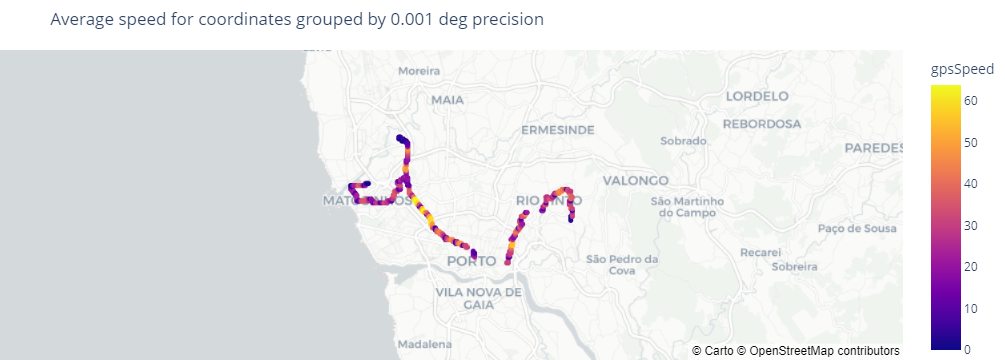

In [391]:
title = f"Average speed for coordinates grouped by 0.001 deg precision"

fig = px.scatter_mapbox(mean_speed, lat="gpsLat", lon="gpsLong", hover_data=["gpsSpeed"], color = "gpsSpeed", zoom=10, title=title)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

### Detect peaks

#### Test the concept

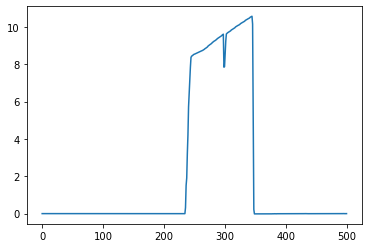

In [411]:
x = metro.TP2[:500]
plt.plot(np.arange(len(x)), x)
plt.show()

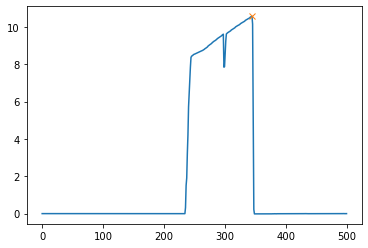

In [416]:
peaks, _ = find_peaks(x, height=8, distance=100)
plt.plot(np.arange(len(x)), x)
plt.plot(peaks, x[peaks], "x")
plt.show()

#### Go further

In [450]:
x = metro.TP2[:10000]
x = x.reset_index(drop=True)
x

0      -0.006
1      -0.006
2      -0.006
3      -0.006
4      -0.006
        ...  
9995   -0.006
9996   -0.006
9997   -0.008
9998   -0.006
9999   -0.008
Name: TP2, Length: 10000, dtype: float64

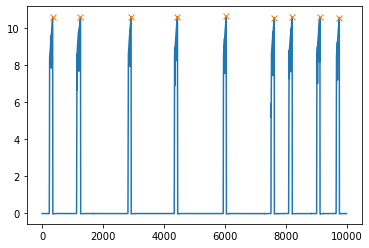

In [451]:
peaks, _ = find_peaks(x, height=10, distance=100)
plt.plot(np.arange(len(x)), x)
plt.plot(peaks, x[peaks], "x")
plt.show()

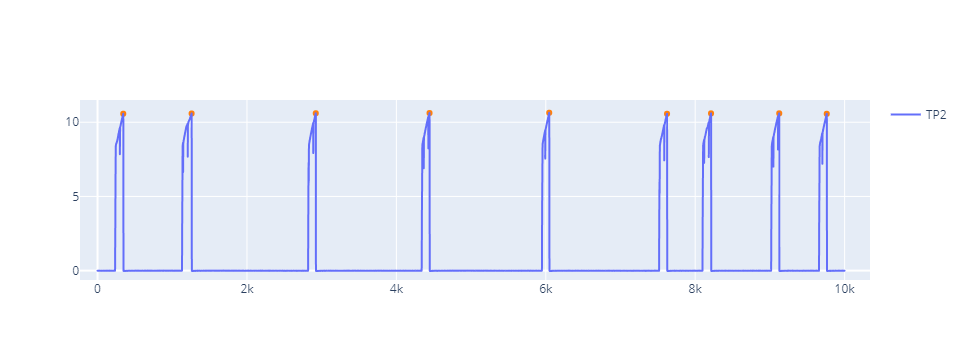

In [473]:
fig1 = px.line(x)
fig2 = px.scatter(x = peaks, y = x[peaks], color_discrete_sequence=['#ff7f0e'])
fig3 = go.Figure(data=fig1.data + fig2.data)
fig3.show()

#### Plot widths
`peak_widths` returns a `tuple(width, y, x_start, x_end)`

In [482]:
widths = peak_widths(x, peaks, rel_height=0.95)
widths 

(array([111.76330365, 131.10383976, 104.42486525, 107.50153724,
         99.88700248, 108.64691291, 117.19616835, 109.52048391,
        106.37824939]),
 array([0.5191, 0.5085, 0.5074, 0.5081, 0.5072, 0.5056, 0.507 , 0.5071,
        0.5075]),
 array([ 235.1726431 , 1130.75813609, 2818.70991736, 4339.26973214,
        5949.08849421, 7517.24154863, 8097.71568627, 9017.16402936,
        9657.56761364]),
 array([ 346.93594675, 1261.86197586, 2923.13478261, 4446.77126938,
        6048.97549669, 7625.88846154, 8214.91185462, 9126.68451327,
        9763.94586302]))

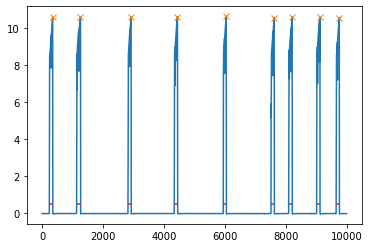

In [483]:
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.hlines(*widths[1:], color="C3")
plt.show()

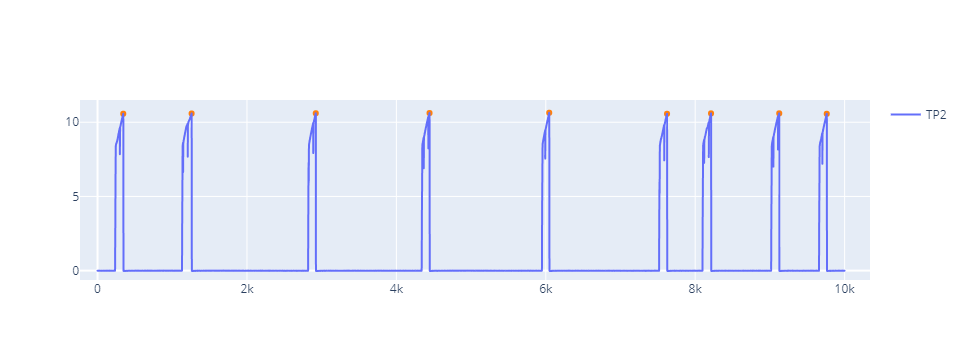

In [484]:
fig1 = px.line(x)
fig2 = px.scatter(x = peaks, y = x[peaks], color_discrete_sequence=['#ff7f0e'])

fig3 = go.Figure(data=fig1.data + fig2.data)
fig3.show()

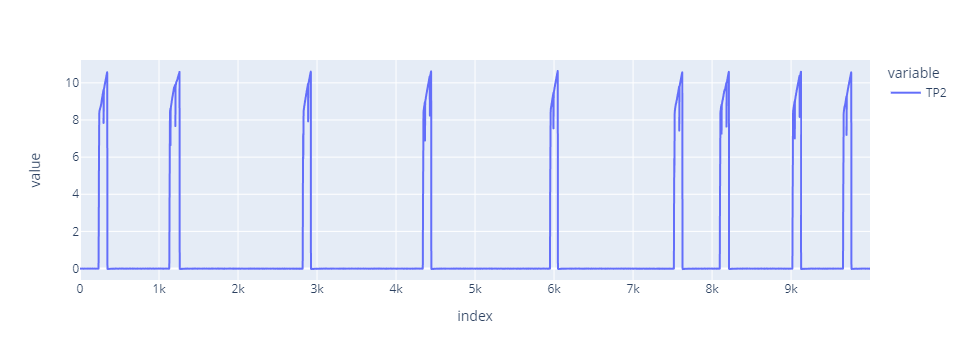

In [488]:
fig = px.line(x)


fig.show()